<a href="https://colab.research.google.com/github/ogbanugot/Kodec/blob/master/SOM_STL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


In [2]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [1]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [1]:
import os
import keras
import numpy as np
import pandas as pd
from time import time

import keras.backend as K
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from drive.minisom.minisom import MiniSom
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Using TensorFlow backend.


In [0]:
def load_stl(data_path='./data/stl'):
    # get labels
    y1 = np.fromfile(data_path + '/train_y.bin', dtype=np.uint8) - 1
    y2 = np.fromfile(data_path + '/test_y.bin', dtype=np.uint8) - 1
    y = np.concatenate((y1, y2))
    
    # get data
    x1 = np.fromfile(data_path + '/train_X.bin', dtype=np.uint8)
    x1 = x1.reshape((int(x1.size/3/96/96), 3, 96, 96)).transpose((0, 3, 2, 1))
    x2 = np.fromfile(data_path + '/test_X.bin', dtype=np.uint8)
    x2 = x2.reshape((int(x2.size/3/96/96), 3, 96, 96)).transpose((0, 3, 2, 1))
    x = np.concatenate((x1, x2)).astype(float)
    return x, y

In [0]:
# from drive.minisom.datasets import load_stl
#, extract_vgg16_features

x, y = load_stl(data_path='drive/minisom/data/stl')


In [0]:
x1 = x[0:3250, :]
x2 = x[3250:6500, :]
x3 = x[6500:9750, :]
x4 = x[9750:13000, :]

In [9]:
x4.shape

(3250, 96, 96, 3)

In [0]:
def extract_vgg16_features(x):
    from keras.preprocessing.image import img_to_array, array_to_img
    from keras.applications.vgg16 import preprocess_input, VGG16
    from keras.models import Model

    # im_h = x.shape[1]
    im_h = 224
    model = VGG16(include_top=True, weights='imagenet', input_shape=(im_h, im_h, 3))
    feature_model = Model(model.input, model.get_layer('fc1').output)
    print('extracting features...')
    x = preprocess_input(x)  # data - 127. #data/255.#
    features = feature_model.predict(x)
    print('Features shape = ', features.shape)
    
    # scale to [0,1]
    from sklearn.preprocessing import MinMaxScaler
    features = MinMaxScaler().fit_transform(features)
    
    return features

In [5]:
from keras.preprocessing.image import img_to_array, array_to_img
from keras import backend as K
# im_h = x.shape[1]
im_h = 224
x_array = []
for im in x1:
  image  = array_to_img(im, scale=False).resize((im_h, im_h))
  image = img_to_array(image)
  x_array.append(image)

x1_array = np.asarray(x_array)
x1 = extract_vgg16_features(x1_array)
K.clear_session()

Instructions for updating:
Colocations handled automatically by placer.
extracting features...
Features shape =  (3250, 4096)


In [0]:
K.clear_session()

In [6]:
from keras.preprocessing.image import img_to_array, array_to_img
# im_h = x.shape[1]
im_h = 224
x_array = []
for im in x2:
  image  = array_to_img(im, scale=False).resize((im_h, im_h))
  image = img_to_array(image)
  x_array.append(image)
  
x2_array = np.asarray(x_array)
x2 = extract_vgg16_features(x2_array)
K.clear_session()

extracting features...
Features shape =  (3250, 4096)


In [0]:
from keras.preprocessing.image import img_to_array, array_to_img
# im_h = x.shape[1]
im_h = 224
x_array = []
for im in x3:
  image  = array_to_img(im, scale=False).resize((im_h, im_h))
  image = img_to_array(image)
  x_array.append(image)
  
x3_array = np.asarray(x_array)
x3 = extract_vgg16_features(x3_array)
K.clear_session()

In [0]:
from keras.preprocessing.image import img_to_array, array_to_img
# im_h = x.shape[1]
im_h = 224
x_array = []
for im in x4:
  image  = array_to_img(im, scale=False).resize((im_h, im_h))
  image = img_to_array(image)
  x_array.append(image)
  
x4_array = np.asarray(x_array)
x4 = extract_vgg16_features(x4_array)
K.clear_session()

In [0]:

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [0]:
# Training the SOM
som = MiniSom(x = 30, y = 30, input_len = 2000, sigma = 4, learning_rate = 0.5, neighborhood_function='triangle')
som.pca_weights_init(train_x)
som.train_random(data = train_x, num_iteration = 5000)

err = som.quantization_error(train_x)
print(err)

In [0]:
map_dim = 30
plt.figure(figsize=(14, 14))
for x, t in zip(train_x, train_y):
    winnin_position = som.winner(x)
    plt.text(winnin_position[0], 
             winnin_position[1]+np.random.rand()*.9, 
             t,
             color=plt.cm.rainbow(t / 4.))

plt.xticks(range(map_dim))
plt.yticks(range(map_dim))
plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()

In [0]:
# Visualizing the training results

plt.figure(figsize=(8, 8))
wmap = {}
im = 0
for x, t in zip(train_x, train_y):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.savefig('drive/minisom/som_reuters.png')
plt.show()



In [0]:
# Get test mappings 
mappings = som.win_map(val_x)
numbers = mappings[(8,1)]
numbers = numbers[0]
#plot number
two_d = (np.reshape(numbers, (28, 28))).astype(np.uint8)
plt.imshow(two_d, interpolation='nearest')



In [0]:
# Visualizing the test results

plt.figure(figsize=(8, 8))
wmap = {}
im = 0
for x, t in zip(val_x, val_y):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.savefig('som_digts.png')
plt.show()

In [0]:
print(wmap[(2,2)])

In [0]:
#Getting Labels for clusters on test set
winlabel = {}
for x, t in zip(val_x, val_y):  
    w = som.winner(x)
    winlabel[w] = t
    
#prediction on the test set
pred  = []
for x in val_x:    
    wt = som.winner(x)
    number = winlabel[wt]
    pred.append(number)


In [0]:
print(normalized_mutual_info_score(val_y, pred))
print(accuracy_score(val_y, pred))

In [0]:
import pickle

# saving the some in the file som.p
with open('drive/minisom/som_reuters.p', 'wb') as outfile:
    pickle.dump(som, outfile)

In [0]:

#load some here
with open('drive/minisom/som_reuters.p', 'rb') as infile:
    som = pickle.load(infile)

In [0]:
# Now instead of directly applying SOM on the problem, 
# we will first use an autoencoder to decrease the dimensionality of the data and extract useful information. 
# This will then pass on the information to the SOM algorithm.


# this is our input placeholder
input_img = Input(shape=(2000,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(2000)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
autoencoder.summary()

In [0]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
#train autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [0]:
train_history = autoencoder.fit(train_x, train_x, epochs=1000, batch_size=2048, validation_data=(val_x, val_x))

Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 2000 samples
Epoch 1/500
8000/8000 [==============================] - 3s 425us/step - loss: 0.9939 - val_loss: 0.9766
Epoch 2/500
8000/8000 [==============================] - 0s 61us/step - loss: 0.9671 - val_loss: 0.9574
Epoch 3/500
8000/8000 [==============================] - 0s 62us/step - loss: 0.9566 - val_loss: 0.9548
Epoch 4/500
8000/8000 [==============================] - 0s 62us/step - loss: 0.9540 - val_loss: 0.9520
Epoch 5/500
8000/8000 [==============================] - 0s 61us/step - loss: 0.9513 - val_loss: 0.9496
Epoch 6/500
8000/8000 [==============================] - 1s 63us/step - loss: 0.9490 - val_loss: 0.9479
Epoch 7/500
8000/8000 [==============================] - 1s 64us/step - loss: 0.9476 - val_loss: 0.9472
Epoch 8/500
8000/8000 [==============================] - 0s 62us/step - loss: 0.9469 - val_loss: 0.9484
Epoch 9/500
8000/8000 [==============================] - 1s 63us/step -

In [0]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)

In [0]:
# Training the SOM
som = MiniSom(x = 30, y = 30, input_len = 10, sigma = 4, learning_rate = 0.5,neighborhood_function='triangle')
som.pca_weights_init(pred_auto_train)
som.train_random(data = pred_auto_train, num_iteration = 5000)


In [0]:
err = som.quantization_error(pred_auto_train)
print(err)

0.6083776092072567


In [0]:
#Getting Labels for clusters on test set
winlabel = {}
for x, t in zip(pred_auto, val_y):  
    w = som.winner(x)
    winlabel[w] = t
    
#prediction on the test set
pred  = []
for x in pred_auto:    
    wt = som.winner(x)
    number = winlabel[wt]
    pred.append(number)


In [0]:
print(normalized_mutual_info_score(val_y, pred))
print(accuracy_score(val_y, pred))

In [0]:
val_y.shape

(2000,)

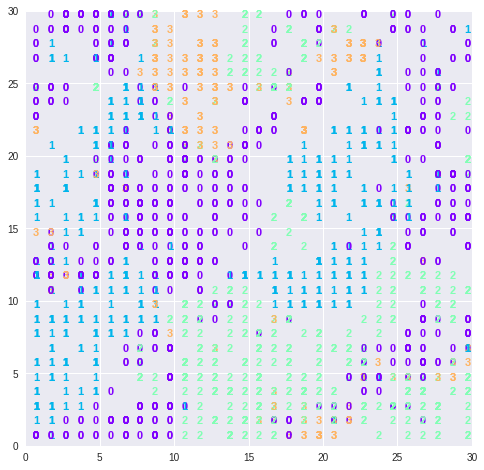

In [0]:
# Visualizing the test results
cat_to_cid = {0:'CCAT', 1:'GCAT', 2:'MCAT', 3:'ECAT'}

plt.figure(figsize=(8, 8))
wmap = {}
im = 0
for x, t in zip(pred_auto, val_y):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5, t,
              color=plt.cm.rainbow(t / 4.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.savefig('drive/minisom/som_reuters_embeded_test.png')
plt.show()